# Load and format data

In [1]:
#from structure_and_load import load
import os
import scipy.io as sio 

import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
def matlab_file_(path):
    """
    Open a matlab behaviour structure from OrganizeBehaviour and save it in a python dictionary. One
    SESSION corresponds to one behavioural file - independently of the number of probes.
    :param filename: name of the matlab structure containing the behavioural information
    :return: behaviour: dictionary containing the same fields as the behaviour structure from matlab
    """
    # initialize a counter for the number of files loaded
    n_file = -1
    # get filenames in list in the session directory
    filenames = os.listdir(path)

    data = [] 
    load_info = []
    
    # Loop through MATLAB files in the session directory
    for matfile in filenames:

        n_file += 1  
        print(f'loading {matfile}')
        load_info.append((n_file, matfile))

        # get the full file path for the current file and load MATLAB file
        filepath = os.path.join(path, matfile) 
        matfile = sio.loadmat(filepath)

        # get the name of the sub-structure within the MATLAB file
        data_str_name = list(matfile.keys())[-1]

        # get the field names within the sub-structure and use them as keys for the new dictionary
    
        fields = []
        for key in matfile[data_str_name].dtype.fields.keys():
            fields.append(key)

        # Extract the data inside the sub-structure and save dictionnary in list
        data_ = matfile[data_str_name][0][0]
        data.append({field: data_[i_field][:, 0] for i_field, field in enumerate(fields)})
        

    print(f'\n{n_file + 1} files loaded')
    
    return data, load_info

In [3]:
session = 't150204001'
data_path = f'/home/laurie/Bureau/pattern_classification/data/Tommy_new/{session}/modified_data/'
info_path = '/home/laurie/Bureau/pattern_classification/data/Tommy_new/session_info.xlsx'
#load data
data, load_info = matlab_file_(data_path)

loading t150204001_probe1_contact6_unit1.mat
loading t150204001_probe2_contact24_unit1.mat
loading t150204001_probe1_contact19_unit1.mat
loading t150204001_probe1_contact17_unit1.mat
loading t150204001_probe1_contact12_unit1.mat
loading t150204001_probe2_contact7_unit4.mat
loading t150204001_probe2_contact14_unit1.mat
loading t150204001_probe2_contact9_unit3.mat
loading t150204001_probe1_contact1_unit1.mat
loading t150204001_probe2_contact23_unit1.mat
loading t150204001_probe2_contact19_unit1.mat
loading t150204001_probe2_contact8_unit1.mat
loading t150204001_probe2_contact21_unit1.mat
loading t150204001_probe1_contact5_unit1.mat
loading t150204001_probe1_contact13_unit1.mat
loading t150204001_probe2_contact10_unit1.mat
loading t150204001_probe2_contact9_unit1.mat
loading t150204001_probe1_contact11_unit3.mat
loading t150204001_probe1_contact4_unit1.mat
loading t150204001_probe2_contact5_unit1.mat
loading t150204001_probe2_contact18_unit1.mat
loading t150204001_probe2_contact2_unit1.ma

# Stucture info session

In [4]:
import re

In [5]:
df = pd.read_excel(info_path)
df.dropna(how='all', inplace=True)
df.drop(columns=['BehDir', 'pitch', 'A/P', 'Lat', 'depth', 'SNR', 'Unnamed: 14', 'depth (no buffer)'], inplace=True)
df.rename(columns={'%Plexon_spike_file' : 'Plexon_spike_file'}, inplace=True)
float_column_names = df.select_dtypes(include=['float']).columns
df[float_column_names] = df[float_column_names].astype(int)

In [6]:
list_prob = []
list_chan = []
list_unit = []

for i in range(len(load_info)) :
    matfile = load_info[i][1]
    # get contact and unit indices from filename
    match_probe = re.search(r'probe(\d+)', matfile)
    match_contact = re.search(r'contact(\d+)', matfile)
    match_unit = re.search(r'unit(\d+)', matfile)

    list_prob.append(int(match_probe.group(1)))
    list_chan.append(int(match_contact.group(1)))
    list_unit.append(int(match_unit.group(1)))

sub_info_session = df[df['Plexon_spike_file'].str.startswith(f'{session}')]


info_session = pd.DataFrame()
list_idx = []
for i in range(len(list_unit)):
    sub_data = sub_info_session[(sub_info_session['probe'] == list_prob[i]) & (sub_info_session['channel'] == list_chan[i]) & (sub_info_session['unit'] == list_unit[i])]
    list_idx.append(sub_data.index[0])
    info_session = pd.concat((info_session, sub_data))

In [7]:
def convert_elitrials(entry):
    if pd.notna(entry):  # Check for NaN
        # Remove square brackets and split by space to separate pairs
        pairs = entry.replace('[', '').replace(']', '').split()
        result = []
        for pair in pairs:
            start, end = map(int, pair.split(':'))
            result.append([start, end])
        return result
    else:
        return None
        
info_session['elitrials'] = info_session['elitrials'].apply(convert_elitrials)

In [8]:
print(info_session.shape)
print(len(load_info))

(45, 8)
43


In [9]:
info_session.sample(5)

,Plexon_spike_file,probe,channel,unit,start,stop,"SUA (1), MUA (2), unstable (3) few trials (4) or observation (5)",elitrials
204,t150204001_chan_25_48_new,2,21,2,4,8,1,None
183,t150204001_chan_25_48_new,2,2,1,1,8,1,"[[129, 139]]"
186,t150204001_chan_25_48_new,2,5,1,8,11,1,"[[123, 128]]"
200,t150204001_chan_25_48_new,2,18,1,1,4,1,"[[71, 74]]"
194,t150204001_chan_25_48_new,2,11,1,1,3,1,"[[50, 54]]"


In [10]:
first_bloc = info_session['start'].min()
last_bloc = info_session['stop'].max()

print(f'start / stop:\n   {first_bloc} /   {last_bloc}')

tasktime = info_session[(info_session['start'] == first_bloc) & (info_session['stop'] == last_bloc) & (info_session['elitrials'].isna())]
tasktimeComplete = tasktime.shape[0] != 0

if tasktimeComplete :
    unit_info = tasktime[['probe', 'channel', 'unit']].values[0]
    print(f"{tasktime[['start', 'stop', 'elitrials']]} \n\nunit_info : {unit_info}")
    matfile = f'{session}_probe{unit_info[0]}_contact{unit_info[1]}_unit{unit_info[2]}.mat'

    for i in load_info:
        if i[1] == matfile:
            completeUnit = i[0]
            print(f"{i[1]}\n\nunit's loading index = {completeUnit}")

else :
    print('ANY UNIT RECORDED OVER ENTIRE SESSION') 
    print(f"check here to construct session times by hand :\n {info_session['start'] == first_bloc}")

tasktime

start / stop:
   1 /   11
     start  stop elitrials
159      1    11      None 

unit_info : [1 3 1]
t150204001_probe1_contact3_unit1.mat

unit's loading index = 32


,Plexon_spike_file,probe,channel,unit,start,stop,"SUA (1), MUA (2), unstable (3) few trials (4) or observation (5)",elitrials
159,t150204001_chan_01_24_new,1,3,1,1,11,1,None


# Stucture data

In [11]:
import numpy as np

In [12]:
# get spike train / periodes times / target info
spike_times = []
task_data = []
target_info = []
target_keys = ['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type']
event_keys_OFF = ['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF']


for unit_idx in range(len(data)):
    spike_times.append((load_info[unit_idx], data[unit_idx]['ts']))  

    # List of keys to extract (excluding 'ts', cues direction and times OFF to be constistent with previous results)
    times_keys = [key for key in data[unit_idx] if key != 'ts' and key not in target_keys and key not in event_keys_OFF]
    task_info = {}
    for key_time in times_keys :
        task_info[key_time] = data[unit_idx][key_time]
    task_data.append((load_info[unit_idx],task_info))

    target_ = {}
    for key_target in target_keys :
        target_[key_target] = data[unit_idx][key_target]
    target_info.append((load_info[unit_idx], target_))

    event_labels = list(task_data[0][1].keys())


print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {target_info[0][1].keys()}')

spike train sample : [    334    5067    6996 ... 3658225 3659812 3660582]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])


## Time

In [13]:
# get event times by trial for each neuron
def events(task_data):
    """
    Retrieves event times from task data file sorts them for each unit

    Args:
    - task_data (list): List of tuples where each tuple contains file information and a dictionary of task-related data.

    Returns:
    - event_times (list of numpy.ndarray): List of arrays containing event times.

    Example usage:
    - event_labels, event_times, event_times_vector = event_times(task_data)
    """

    # Get event times by event labels
    event_times = []
    for unit_idx in range(len(task_data)):
        times = []
        for event in event_labels:
            times.append(task_data[unit_idx][1][event])
        event_times.append((task_data[unit_idx][0], np.array(times, dtype=object)))

    return event_times

event_times = events(task_data)

In [14]:
unit_ = 0
tstart = 0
tstop = 8

print(f'unit file : {event_times[unit_][0][1]}\n')
for event in range(len(event_labels)):
    print(f'n_trials = {len(event_times[unit_][1][event])}')
    print(f'{event_labels[event]} from trial {tstart} to trial {tstop}')
    print(event_times[unit_][1][event][tstart:tstop])

unit file : t150204001_probe1_contact6_unit1.mat

n_trials = 49
Touch_time from trial 0 to trial 8
[2330253 2465671 2475949 2716143 2758148 2769184 2778912 2795883]
n_trials = 49
Sel_ON from trial 0 to trial 8
[2331358 2466748 2477014 2717230 2759224 2770251 2779982 2796950]
n_trials = 49
SC1_ON from trial 0 to trial 8
[2332679 2468070 2478323 2718548 2760533 2771559 2781317 2798271]
n_trials = 49
SC2_ON from trial 0 to trial 8
[2334014 2469378 2479631 2719869 2761854 2772867 2782626 2799579]
n_trials = 49
SC3_ON from trial 0 to trial 8
[2335349 2470700 2480952 2721191 2763176 2774189 2783934 2800888]
n_trials = 49
Go_time from trial 0 to trial 8
[2336647 2472002 2482238 2722476 2764460 2775474 2785233 2802173]
n_trials = 49
Target_time from trial 0 to trial 8
[2337168 2472665 2482998 2723130 2765104 2776115 2785700 2802678]


In [15]:
unit_ = completeUnit
tstart = 0
tstop = 8

print(event_times[unit_][0])
for event in range(len(event_labels)):
    print(f'n_trials = {len(event_times[unit_][1][event])}')
    print(f'{event_labels[event]} from trial {tstart} to trial {tstop}')
    print(event_times[unit_][1][event][tstart:tstop])

(32, 't150204001_probe1_contact3_unit1.mat')
n_trials = 176
Touch_time from trial 0 to trial 8
[61233 105639 179281 216446 226804 244498 255327 270484]
n_trials = 176
Sel_ON from trial 0 to trial 8
[62310 106751 180344 217522 227881 245596 256410 271562]
n_trials = 176
SC1_ON from trial 0 to trial 8
[63629 108096 181696 218831 229203 246905 257731 272870]
n_trials = 176
SC2_ON from trial 0 to trial 8
[64937 109404 183014 220139 230511 248213 259039 274191]
n_trials = 176
SC3_ON from trial 0 to trial 8
[66258 110712 184322 221460 231836 249521 260365 275513]
n_trials = 176
Go_time from trial 0 to trial 8
[67543 111997 185620 222763 233148 250846 261660 276815]
n_trials = 176
Target_time from trial 0 to trial 8
[68156 112550 186341 223389 233869 251440 262113 277319]


In [16]:
# reshape times by trials / periods for each neuron + Neo format
import numpy as np
import pandas as pd
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms
import numpy as np

# to go further with NEO : https://neo.readthedocs.io/en/stable/grouping.html


def events_by_trial(event_times, event_labels):
    '''
    Structure periods timestamps by trial and store in a data frame.

    Args:
    - event_times (numpy.ndarray): Array of event times where rows represent events, and columns represent trials.
    - event_labels (list): List of event labels corresponding to the columns of the data frame.

    Returns:
    - trials_ts (list of numpy.ndarray): List of event times structured by trial.
    - df_task_ts (list of pandas.DataFrame): List of data frames containing event times structured by trial.
    - events (list of list): List of Event objects.

    '''
    trials_ts = []  # List to store event times structured by trial
    df_task_ts_by_neuron = []  # List to store data frames containing event times structured by trial
    events = []  # List to store Event objects

    for unit_idx in range(len(event_times)):
        n_events = event_times[unit_idx][1].shape[0]
        n_trials = event_times[unit_idx][1].shape[1]

        events_ts = np.zeros((n_trials, n_events), dtype=int)
        event_list = []

        # Split time stamps for each period according to the trial
        for trial in range(n_trials):
            for event in range(n_events):
                events_ts[trial][event] = event_times[unit_idx][1][event][trial]
            
            event_list.append(Event(events_ts[trial] * ms, labels=event_labels, dtype='U'))

        events.append((event_times[unit_idx][0], event_list))
        trials_ts.append((event_times[unit_idx][0], events_ts))
        task_ts = pd.DataFrame(events_ts, columns=event_labels)
        df_task_ts_by_neuron.append((event_times[unit_idx][0], task_ts))

    return trials_ts, df_task_ts_by_neuron, events

trials_ts, df_task_ts_by_neuron, events = events_by_trial(event_times, event_labels)

unit_ = 6
trial_ = 0
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
df_task_ts_by_neuron[unit_][1].head()

times as list : [1026429 1027493 1028801 1030123 1031431 1032716 1033250]
times as neo events : [1026429. 1027493. 1028801. 1030123. 1031431. 1032716. 1033250.] ms


,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
0,1026429,1027493,1028801,1030123,1031431,1032716,1033250
1,1035281,1036357,1037665,1038974,1040282,1041567,1042151
2,1108631,1109726,1111034,1112343,1113651,1114936,1115725
3,1129500,1130605,1131913,1133222,1134546,1135842,1136375
4,1139902,1140978,1142286,1143594,1144902,1146190,1146777


In [17]:
unit_ = completeUnit
trial_ = 0
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
df_task_ts_by_neuron[unit_][1].tail()

times as list : [61233 62310 63629 64937 66258 67543 68156]
times as neo events : [61233. 62310. 63629. 64937. 66258. 67543. 68156.] ms


,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


## SPIKE 

In [18]:
# get spike by trial for each neuron + Neo format (SpikeTrain)
from neo.core import SpikeTrain

def spike_by_trial_only(trials_ts, spike_times):  
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_trials = []
    spike_train = []

    
    n_neurons = len(spike_times)

    for unit_idx in range(n_neurons):
        spk_trials.append([])
        spike_train.append([])

        n_trials = trials_ts[unit_idx][1].shape[0]

        for trial in range(n_trials):
            # define the start and end time of each trial
            t_start = trials_ts[unit_idx][1][trial,0]
            t_stop = trials_ts[unit_idx][1][trial,-1]
            
            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit_idx][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            
            # for trials without spikes 
            if spk_tmp[sel_spk].shape[0] == 0:
                spk_trials[unit_idx].append([])
                spike_train[unit_idx].append([])

            else :
                spk_ts_trial = spk_tmp[sel_spk] 
                # fill the matrice with spike times aligned to 0
                spk_trials[unit_idx].append(spk_ts_trial)
                spike_train[unit_idx].append(spk_ts_trial* ms)

    return spk_trials, spike_train


In [19]:
spk_trials, spike_train_trial = spike_by_trial_only(trials_ts, spike_times)

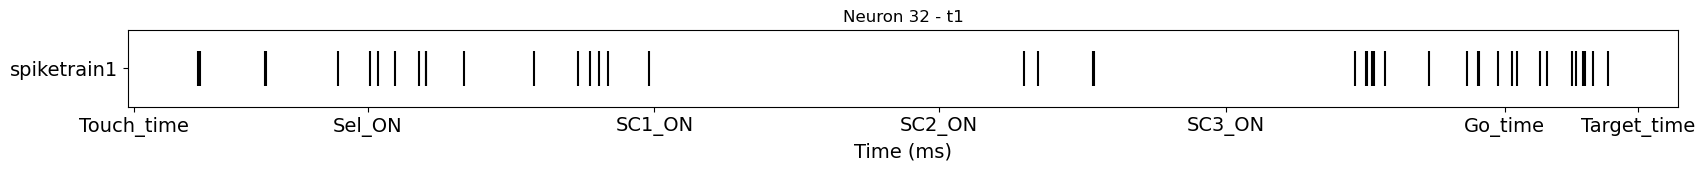

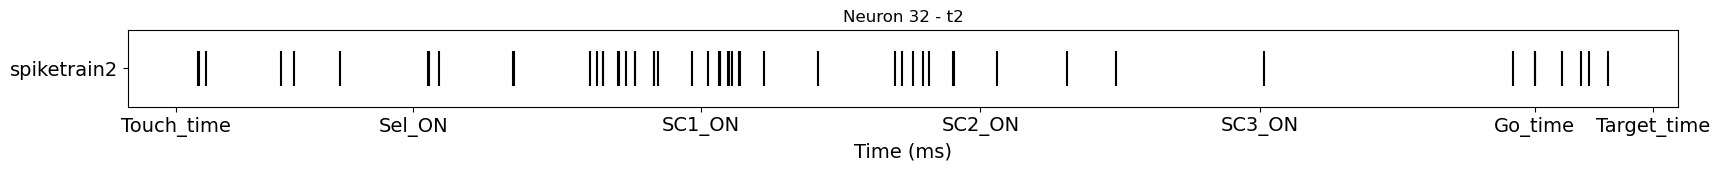

In [20]:
import matplotlib.pyplot as plt 

neuron = 32

spiketrain1 = spike_train_trial[neuron][0]
spiketrain2 = spike_train_trial[neuron][1]

plt.figure(figsize=(20, 1))
plt.eventplot(spiketrain1.magnitude, linelengths=0.75, color='black')
plt.xticks(trials_ts[neuron][1][0], event_labels,fontsize=14)

plt.xlabel('Time (ms)', fontsize=14)
plt.yticks([1], labels=["spiketrain1"], fontsize=14)
plt.title(f"Neuron {neuron} - t1");

plt.figure(figsize=(20, 1))
plt.eventplot(spiketrain2.magnitude, linelengths=0.75, color='black')
plt.xticks(trials_ts[neuron][1][1], event_labels,fontsize=14)

plt.xlabel('Time (ms)', fontsize=14)
plt.yticks([1], labels=["spiketrain2"], fontsize=14)
plt.title(f"Neuron {neuron} - t2");

## Target 

In [21]:
# get target by trial and neuron
n_units = len(target_info)

list_trial_type = []
list_position = []
list_type_and_pos = []

for unit in range(n_units):
    #print(f'neuron {unit}')
    list_trial_type.append([])
    list_position.append([])
    list_type_and_pos.append([])
    trial_type = target_info[unit][1]['Trial_type']
    n_trials = trial_type.shape[0]

    for trial in range(n_trials):
        #print(f'trial type : {trial_type[trial]}')
        valid_cue_idx = target_info[unit][1]['Trial_type'][trial] - 1
        valid_cue = list(target_info[unit][1].keys())[valid_cue_idx]
        position = target_info[unit][1][f'{valid_cue}'][trial]
        #print(f'position : {position}')
        list_trial_type[unit] = list(trial_type)
        list_position[unit].append(position)

    cue_position = list(zip(list_trial_type[unit], list_position[unit]))
    cue_pos_combinations = sorted(set(cue_position))

    # build the target accoring the combination of the cue/direction
    cue_and_pos = []
    for sel_cue, direction in cue_position:
        cue_and_pos.append(cue_pos_combinations.index((sel_cue, direction)))

    list_type_and_pos[unit] = cue_and_pos

# Compute

In [22]:
from neo.core import SpikeTrain
from elephant.statistics import mean_firing_rate

In [23]:
total_trial_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, total_trial_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


In [24]:
# check trials alignement between neurons or with the complete time line
unit_ = 38

print(spike_times[unit_][0], df_task_ts_by_neuron[38][1].shape)

idx_min_trial = df_task_ts_by_neuron[unit_][1].index[0]
idx_max_trial = df_task_ts_by_neuron[unit_][1].index[-1]
idx_trials = np.arange(idx_min_trial, idx_max_trial + 1) 

t_start = df_task_ts_by_neuron[unit_][1].loc[idx_min_trial]['Touch_time']
idx_start = df_task_ts[df_task_ts['Touch_time'] == t_start].index
print(df_task_ts.loc[idx_start])

t_stop = df_task_ts_by_neuron[unit_][1].loc[idx_max_trial]['Target_time']
idx_stop = df_task_ts[df_task_ts['Target_time'] == t_stop].index
print(df_task_ts.loc[idx_stop])

print(spike_times[unit_][0], df_task_ts_by_neuron[unit_][1].shape)
print(idx_stop[0] - idx_start[0])

(38, 't150204001_probe2_contact6_unit1.mat') (65, 7)
    Touch_time   Sel_ON   SC1_ON   SC2_ON   SC3_ON  Go_time  Target_time
91     1903682  1904816  1906134  1907442  1908751  1910049      1910596
     Touch_time   Sel_ON   SC1_ON   SC2_ON   SC3_ON  Go_time  Target_time
155     3047992  3049069  3050391  3051713  3053021  3054320      3054799
(38, 't150204001_probe2_contact6_unit1.mat') (65, 7)
64


## Firing rate

In [25]:
n_units = len(spike_times)
n_event = event_labels[:-1]

cols = []
for i in range(n_units): 
    cols.append(f'neuron{i}')   

cols.insert(0, 'period')
cols.insert(1, 'trial_type')
cols.insert(2, 'position')
cols.insert(3, 'type_and_pos')



list_df_spk = []
list_spike_train = []
list_idx_trial = []

for i, event in enumerate(event_labels[:-1]):
    #print(event)
    df = pd.DataFrame(columns=cols, index=df_task_ts.index)
    df['period'] = event
    list_spike_train.append([])

    for unit in range(n_units) :
        #print(f'NEURON : {unit}')
        #print(spike_times[unit][0])
        times_unit = df_task_ts_by_neuron[unit][1]
        n_trials = times_unit.shape[0]

        list_spike_train[i].append([])
        list_idx_trial.append([])


        for trial in range(n_trials):            #print(f'trial :{trial}')
            t_start = times_unit.loc[trial][f'{event}']
            t_stop = times_unit.loc[trial][f'{event_labels[i+1]}']
            #print(t_start, t_stop)

            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            #print(spk_tmp[sel_spk])


            spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop)
            list_spike_train[i][unit].append(spk_ts_trial)

            mean_fr = mean_firing_rate(spk_ts_trial)*1000 
            #print(df_task_ts[df_task_ts[f'{event}'] == t_start])

            idx_trial = df_task_ts[df_task_ts[f'{event}'] == t_start].index[0]

            if i == 0 : 
                list_idx_trial[unit].append(idx_trial)

            #print(mean_fr.magnitude)

            df.loc[idx_trial, f'neuron{unit}'] = mean_fr.magnitude
            df.loc[idx_trial, 'trial_type'] = list_trial_type[unit][trial]
            df.loc[idx_trial, 'position'] = list_position[unit][trial]
            df.loc[idx_trial, 'type_and_pos'] = list_type_and_pos[unit][trial]

    list_df_spk.append(df)
    

In [26]:
target = {\
    'trial_type' : list_df_spk[0]['trial_type'].values, 
    'position' : list_df_spk[0]['position'].values, 
    'type_and_pos': list_df_spk[0]['type_and_pos'].values}

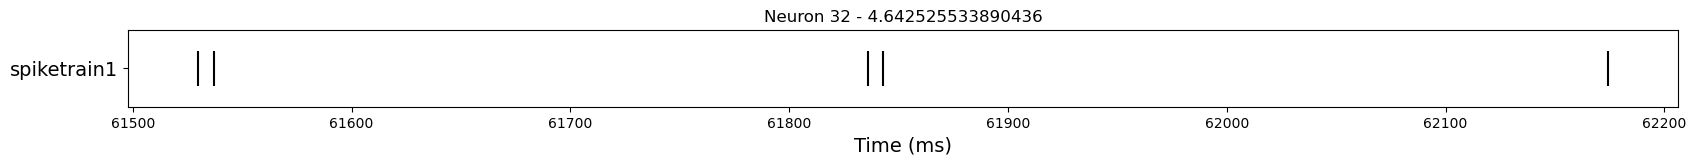

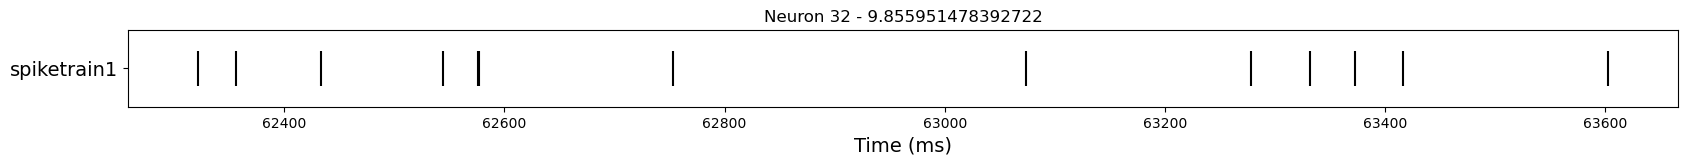

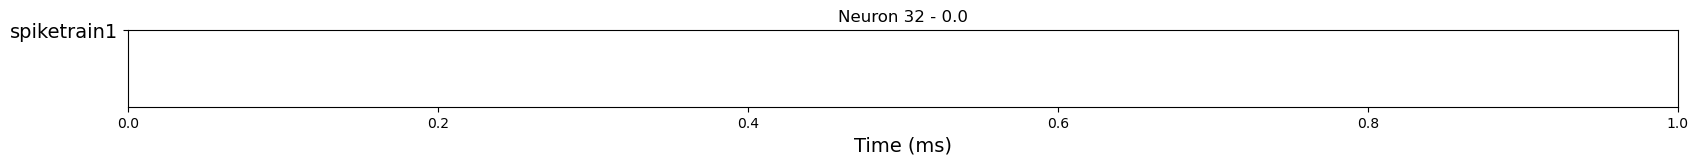

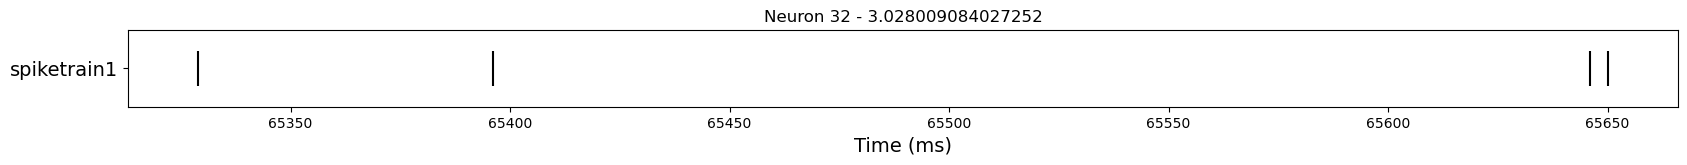

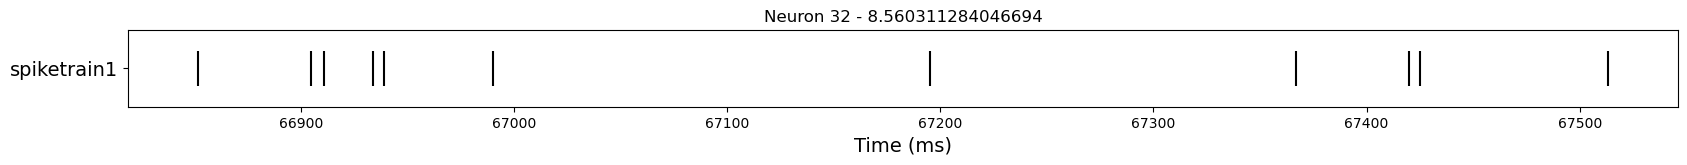

In [27]:
import matplotlib.pyplot as plt 

trial = 0
neuron = 32

for i in range(0,5): 
    spiketrain = list_spike_train[i][neuron][trial]
    #x_axis = np.arange(df_task_ts_by_neuron[neuron][1].loc[trial][i], df_task_ts_by_neuron[neuron][1].loc[trial][i+1])

    plt.figure(figsize=(20, 1))
    plt.eventplot(spiketrain.magnitude, linelengths=0.75, color='black')
    #plt.xticks(np.arange(spiketrain.t_start, spiketrain.t_stop))

    plt.xlabel('Time (ms)', fontsize=14)
    plt.yticks([1], labels=["spiketrain1"], fontsize=14)
    plt.title(f"Neuron {neuron} - {list_df_spk[i].loc[trial][f'neuron{neuron}']}");

# Classify

## Firing rate 

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline



In [29]:
# Build pipeline
n_splits = 10
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
scaler = StandardScaler()
estimator = HistGradientBoostingClassifier()
clf = make_pipeline(scaler, estimator)

In [30]:
def struct_dataset(df_feature, target, measure):
    
    if measure == 'sync':
        cols_to_drop = list(df_feature.columns[0:5])
    else:
        cols_to_drop = list(df_feature.columns[0:4])

    data = df_feature.drop(columns=cols_to_drop)
    target = pd.DataFrame(target, dtype='uint8')


    return data, target

In [31]:
class Model_info:

    def __init__(self, n_splits, n_events, data, target, cvs, clf):
        self.n_splits = n_splits
        self.n_periods = n_events
        self.data = data
        self.target = target
        self.cvs = cvs
        self.clf = clf

In [32]:
n_events = len(event_labels) - 1

list_data_sync = []
list_target_sync = []
list_sync_model = []
list_data_rate = []
list_target_rate = []
list_rate_model = []


In [33]:
for event in range(n_events):
    
    list_data_sync.append([])
    list_target_sync.append([])
    list_sync_model.append([])

    #list_df_spk[event] = list_df_spk[event].fillna(0)

    data_rate, target_rate = struct_dataset(\
        list_df_spk[event], target, measure ='rate')

    model_rate = Model_info(n_splits,\
             n_events, data_rate, target_rate, cvs0, clf)

    list_data_rate.append(data_rate)
    list_target_rate.append(target_rate)
    list_rate_model.append(model_rate)

In [35]:
list_rate_model[0].data

,neuron0,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,...,neuron33,neuron34,neuron35,neuron36,neuron37,neuron38,neuron39,neuron40,neuron41,neuron42
0,NaN,NaN,5.571030640668524,2.785515320334262,38.99721448467967,NaN,NaN,2.785515320334262,NaN,2.785515320334262,...,1.8570102135561746,3.714020427112349,NaN,NaN,NaN,NaN,NaN,NaN,11.142061281337048,0.0
1,NaN,NaN,10.79136690647482,4.496402877697841,37.76978417266187,NaN,NaN,1.7985611510791368,NaN,2.697841726618705,...,1.7985611510791368,0.0,NaN,NaN,NaN,NaN,NaN,NaN,12.589928057553957,1.7985611510791368
2,NaN,NaN,15.051740357478835,12.229539040451552,39.51081843838194,NaN,NaN,2.8222013170272815,NaN,19.75540921919097,...,15.992474129821261,14.111006585136407,NaN,NaN,NaN,NaN,NaN,NaN,15.992474129821261,2.8222013170272815
3,NaN,NaN,12.081784386617102,6.5055762081784385,34.386617100371744,NaN,NaN,2.7881040892193307,NaN,15.799256505576206,...,9.29368029739777,16.728624535315983,NaN,NaN,NaN,NaN,NaN,NaN,10.223048327137546,0.929368029739777
4,NaN,NaN,9.285051067780872,7.428040854224698,26.92664809656453,NaN,NaN,6.49953574744661,NaN,12.99907149489322,...,24.141132776230272,6.49953574744661,NaN,NaN,NaN,NaN,NaN,NaN,11.142061281337048,1.8570102135561746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,2.806361085126286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.483629560336763,NaN,1.8709073900841908,4.677268475210477,NaN,NaN
172,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.442776735459663,NaN,9.380863039399626,0.9380863039399625,NaN,NaN
173,2.6833631484794274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11.627906976744185,NaN,0.8944543828264758,1.7889087656529516,NaN,NaN
174,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.554307116104869,NaN,0.9363295880149812,4.681647940074907,NaN,NaN


In [34]:
def classif_rate(list_model, periods_names):

    #acc = np.zeros(list_model[0][0].n_splits)
    #acc_shuf = np.zeros(list_model[0][0].n_splits)
    #acc_df = pd.DataFrame(\
    #    columns=['split', 'data_type', 'period', 'target_type', 'accuracy', 'y_true', 'y_pred'])

    acc_df = pd.DataFrame(\
        columns=['split', 'data_type', 'period', 'target_type', 'accuracy'])

 
    model_ = list_model[0]
    data_ = list_model[0].data
    target_ = list_model[0].target
    n_periods = list_model[0].n_periods
    n_targets = list_model[0].target.shape[1]


    for i_split, (train_ind, test_ind) in enumerate(model_.cvs.split(data_,target_)):

        print('#################')
        print('SPLIT :', i_split)
        print('##################')
        
        for per_idx in range(n_periods):
    
    
            model = list_model[per_idx]
            data = model.data

            for idx_target in range(n_targets):
                

                target_ =  model.target.iloc[:,idx_target]
                target_name = model.target.columns[idx_target]

                #print(periods_names[per_idx], sigma[sig_indx], target_name)

                # train classifier 
                model.clf.fit(data.loc[train_ind,:], target_.loc[train_ind])
            
                # test classifier 
                y_pred =  model.clf.predict(data.loc[test_ind,:])
                y_true = target_.loc[test_ind].values
                
                #acc = accuracy_score(y_true, y_pred)
                acc = model.clf.score(data.loc[test_ind,:], target_.loc[test_ind])
                
                
                # save test perfomance
                d = {
                    'split' : [i_split],
                    'data_type': ['test'],
                    'period': [f'{periods_names[per_idx]}'],
                    'target_type' : target_name, 
                    'accuracy': [acc],
                    }

                acc_df = pd.concat((acc_df, pd.DataFrame(data=d)), ignore_index=True)
            
                #  train classfier on shuffled data
                ind_train_shuf = np.random.permutation(train_ind)
                model.clf.fit(data.loc[train_ind,:],  target_.loc[ind_train_shuf])
            
                # test classfier on shuffled data
                y_pred_shuf =  model.clf.predict(data.loc[test_ind,:])
                #acc_shuf = accuracy_score(y_true, y_pred_shuf)
                acc_shuf = model.clf.score(data.loc[test_ind,:], target_.loc[test_ind])

                
                # save shuffled perfomance
                d_shuff = {
                    'split' : [i_split],
                    'data_type': ['shuff'],
                    'period': [f'{periods_names[per_idx]}'],
                    'target_type' : target_name, 
                    'accuracy': [acc_shuf],
                    }
            
                acc_df = pd.concat((acc_df, pd.DataFrame(data=d_shuff)), ignore_index=True)

    return acc_df


In [89]:
#periods_names = list(task_info.keys())
acc_df = classif_rate(list_rate_model, event_labels)


#################
SPLIT : 0
##################
#################
SPLIT : 1
##################
#################
SPLIT : 2
##################
#################
SPLIT : 3
##################
#################
SPLIT : 4
##################
#################
SPLIT : 5
##################
#################
SPLIT : 6
##################
#################
SPLIT : 7
##################
#################
SPLIT : 8
##################
#################
SPLIT : 9
##################


In [91]:
acc_df.to_csv('acc_df_Grad_{session}_without_nan.csv')

# Plot

## Accuracy firing rate

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")


In [58]:
acc_df

,split,data_type,period,target_type,accuracy
0,0,test,Touch_time,trial_type,0.833333
1,0,shuff,Touch_time,trial_type,0.361111
2,0,test,Touch_time,position,0.277778
3,0,shuff,Touch_time,position,0.277778
4,0,test,Touch_time,type_and_pos,0.166667
...,...,...,...,...,...
355,9,shuff,Go_time,trial_type,0.583333
356,9,test,Go_time,position,0.972222
357,9,shuff,Go_time,position,0.416667
358,9,test,Go_time,type_and_pos,0.666667


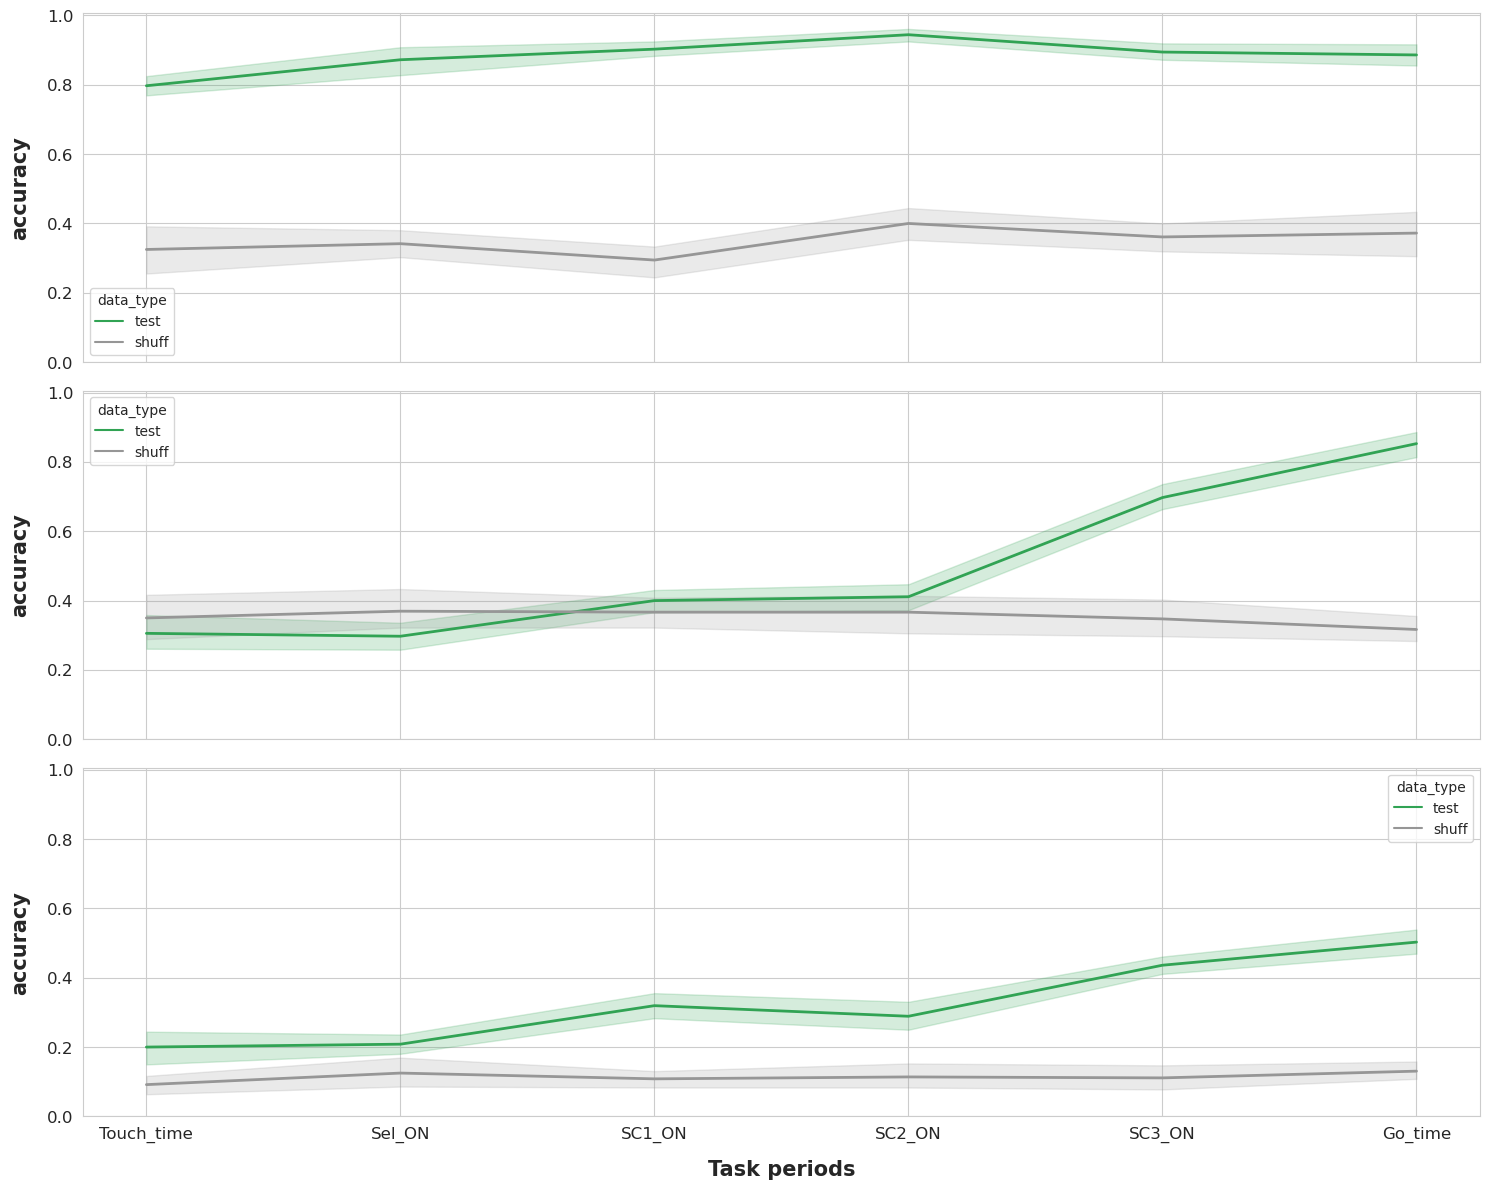

In [93]:
spk_accuracy = acc_df
target_list = ['trial_type', 'position', 'type_and_pos']

palette_spk = ['#31a354', '#969696']


plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12 

fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey= True, dpi=100)  

#axs[0,0].set_ylabel('Type\n', fontsize=14, weight='bold')
#axs[1,0].set_ylabel('Position\n', fontsize=14, weight='bold')
#axs[2,0].set_ylabel('Type and position\n', fontsize=14, weight='bold')
legend_labels = []
legend_handles = []


for i, target in enumerate(target_list):

    accuracy_plot = spk_accuracy.rename(columns={"period": "Task periods", "score" : "accuracy"}, inplace=False)#\
    #.replace(to_replace = periods_names[:-2], value=['Touch', 'Selection Cue', 'Spatial Cue 1', 'Spatial Cue 2', 'Spatial Cue 3', 'Go'], inplace=False)\
    #.replace(to_replace=['test', 'shuff'], value=['test', 'shuffled'], inplace=False)
    
    accuracy_plot = accuracy_plot[accuracy_plot["target_type"] == target]

    sns.lineplot(accuracy_plot, x='Task periods', y='accuracy', hue='data_type', palette=palette_spk, linewidth = 2., ax=axs[i])

    #axs[0,0].set_title('Firing-rate decoding', fontsize= 16, weight='bold')
    axs[i].set_yticks(np.arange(0,1.1,0.2))
    

plt.tight_layout()

#time = datetime.now().strftime('%d_%m_%H_%M_%S')
#plt.savefig(f'./results/figures_results/accuracy_{time}.png'


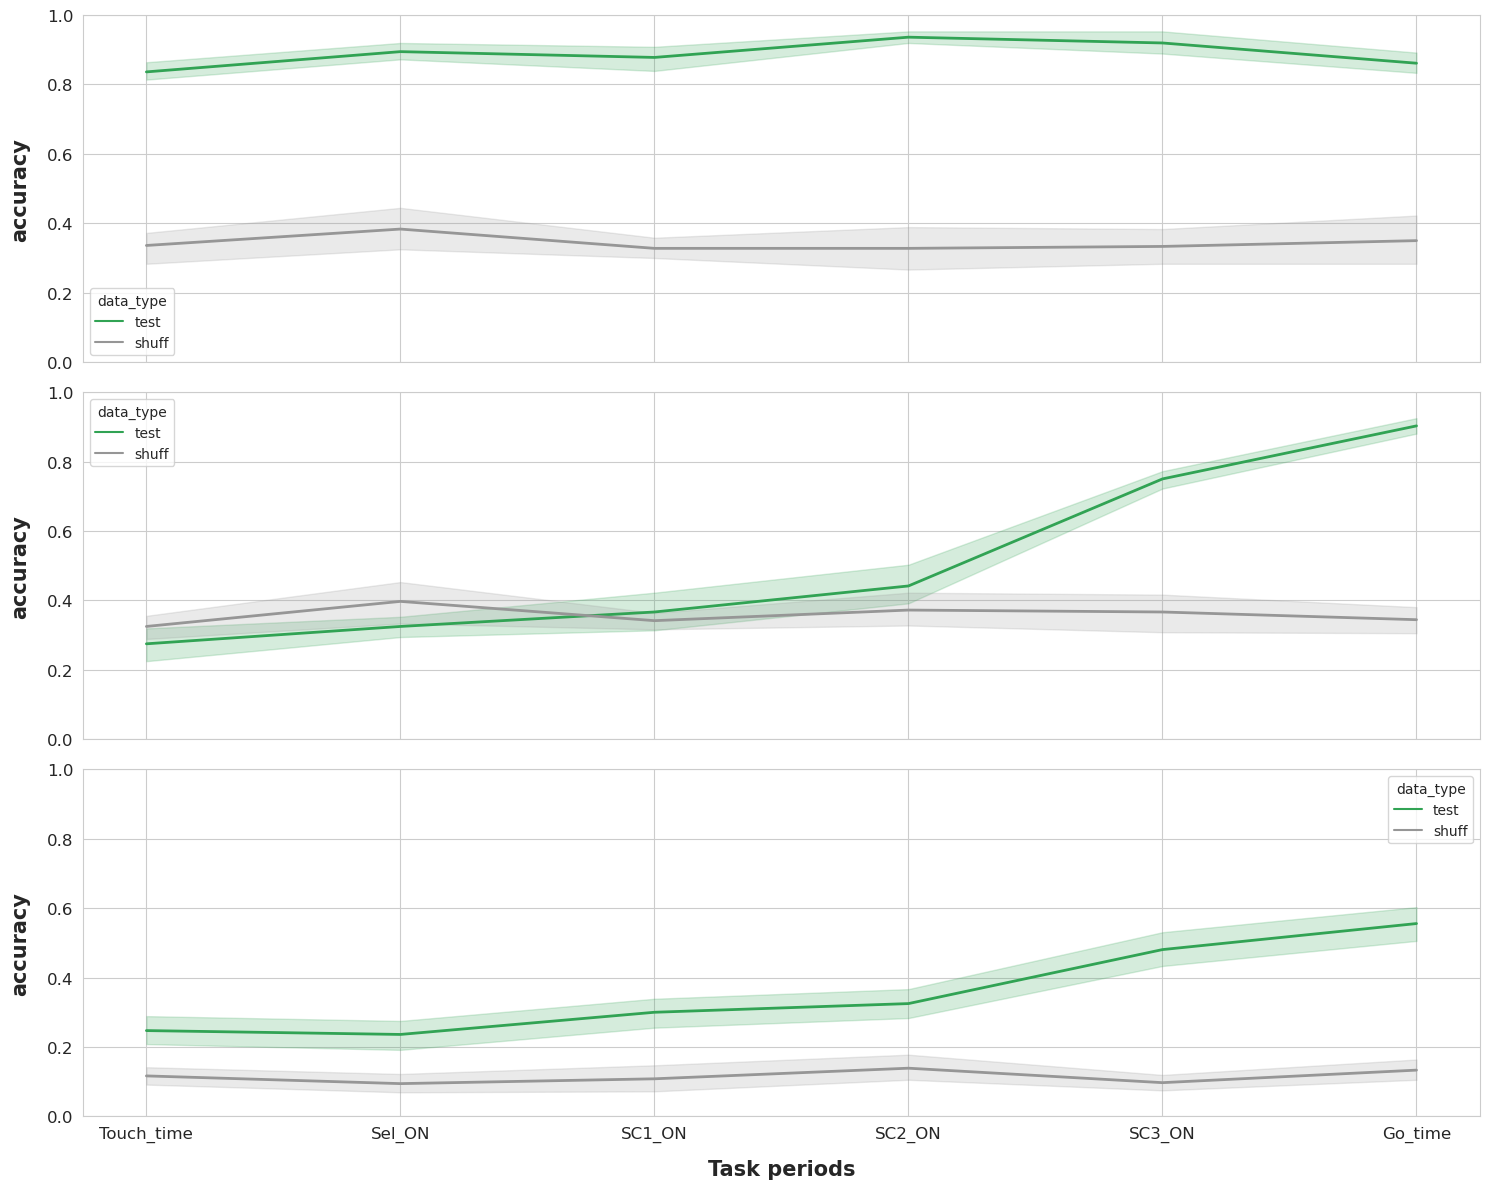

In [57]:
spk_accuracy = acc_df
target_list = ['trial_type', 'position', 'type_and_pos']

palette_spk = ['#31a354', '#969696']


plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["xtick.labelsize"] = 12  
plt.rcParams["ytick.labelsize"] = 12 

fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey= True, dpi=100)  

#axs[0,0].set_ylabel('Type\n', fontsize=14, weight='bold')
#axs[1,0].set_ylabel('Position\n', fontsize=14, weight='bold')
#axs[2,0].set_ylabel('Type and position\n', fontsize=14, weight='bold')
legend_labels = []
legend_handles = []


for i, target in enumerate(target_list):

    accuracy_plot = spk_accuracy.rename(columns={"period": "Task periods", "score" : "accuracy"}, inplace=False)#\
    #.replace(to_replace = periods_names[:-2], value=['Touch', 'Selection Cue', 'Spatial Cue 1', 'Spatial Cue 2', 'Spatial Cue 3', 'Go'], inplace=False)\
    #.replace(to_replace=['test', 'shuff'], value=['test', 'shuffled'], inplace=False)
    
    accuracy_plot = accuracy_plot[accuracy_plot["target_type"] == target]

    sns.lineplot(accuracy_plot, x='Task periods', y='accuracy', hue='data_type', palette=palette_spk, linewidth = 2., ax=axs[i])

    #axs[0,0].set_title('Firing-rate decoding', fontsize= 16, weight='bold')
    axs[i].set_yticks(np.arange(0,1.1,0.2))
    

plt.tight_layout()

#time = datetime.now().strftime('%d_%m_%H_%M_%S')
#plt.savefig(f'./results/figures_results/accuracy_{time}.png'


# SYNCH

In [41]:
def align_time(df_task_ts):
    times_aligned = np.array(df_task_ts)

    for trial in range(len(times_aligned)):
        times_aligned[trial] -= times_aligned[trial][0]
         

    times_aligned = np.array(times_aligned, dtype=object)

    return times_aligned

times_aligned = align_time(df_task_ts)

In [42]:
from neo.core import SpikeTrain
from elephant.statistics import mean_firing_rate


def align_spike(trials_ts, spike_times, event_labels): 
     
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    n_neurons = len(spike_times)

    spikes_aligned = []    
    spikes_binarized = []

    for unit_idx in range(n_neurons):
        spikes_aligned.append([])
        spikes_binarized.append([])

        spk_tmp = spike_times[unit_idx][1] 
        n_trials = trials_ts[unit_idx][1].shape[0]  

        for trial in range(n_trials):
            spikes_aligned[unit_idx].append([])
            spikes_binarized[unit_idx].append([])

            for event in range(len(event_labels) - 1):
                # define the start and end time of each trial
                t_start = trials_ts[unit_idx][1][trial,event]
                t_stop = trials_ts[unit_idx][1][trial, event+1]
                # get spikes between start and end of trial and align to zero
                sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
                spikes_aligned[unit_idx][trial].append(spk_tmp[sel_spk] - t_start)
                
                # get continuous spike trains
                n_times = (t_stop - t_start)
                spikes_binarized[unit_idx][trial].append(np.linspace(0, 0, num=n_times+1,  dtype=float))

                for spk in spk_tmp[sel_spk]:
                    spk_aligned = spk - t_start
                    spikes_binarized[unit_idx][trial][event][spk_aligned] = 1

    return  spikes_aligned, spikes_binarized

In [43]:
spikes_aligned, spikes_binarized = align_spike(trials_ts, spike_times, event_labels)

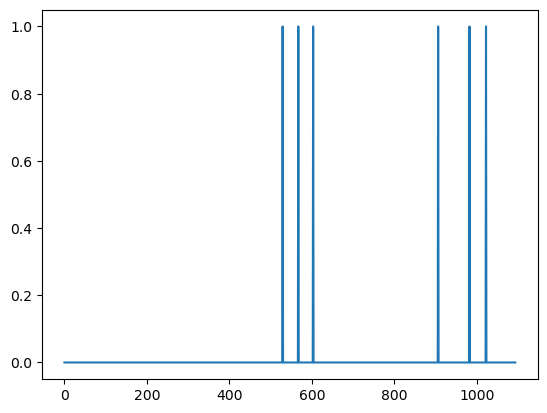

In [44]:
plt.plot(spikes_binarized[0][0][0])

In [337]:
sigma = [50]
delta_time = 1
sigma_dt = sigma * delta_time 

sigma_dt

[50]

In [63]:
list_idx_trial[20]

[8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75]

In [64]:
list_idx_trial = list_idx_trial[:21]

In [65]:
len(list_idx_trial)

21

In [91]:
df_task_ts.loc[0]['Touch_time']

36636

In [89]:
list(df_task_ts.columns)[:-1]

['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time']

In [112]:
import scipy.ndimage as spn 

n_units = len(spikes_aligned)
n_trials = df_task_ts.shape[0]
events = list(df_task_ts.columns)
n_events = len(events) - 1

spike_convolved = []


for unit in range(n_units):
    spike_convolved.append([])
    for trial in range(n_trials):
        spike_convolved[unit].append([])
        for i in range(n_events): 
            spike_convolved[unit][trial].append([])

            # define the start and end time of each trial
            t_start = df_task_ts.loc[trial][f'{events[i]}']
            t_stop =  df_task_ts.loc[trial][f'{events[i+1]}']
            n_times = (t_stop - t_start)
            
            spike_convolved[unit][trial][i].append(np.linspace(0, 0, num=n_times+1,  dtype=float))

In [115]:
spike_convolved[0][0][0]

[array([0., 0., 0., ..., 0., 0., 0.])]

In [124]:
len(spikes_binarized[1][0])

6

In [140]:

sigma = [50]
delta_time = 1
sigma_dt = sigma * delta_time 

for unit in range(n_units):
    #print('unit')
    #print(unit)
    for t, trial_unit in enumerate(list_idx_trial[unit]):
        #print(trial)
        for i in range(n_events):
            #print('period id')
            #print(i)  
            for s in range(len(sigma)):
                scaling = sigma_dt[s] * np.sqrt(2*np.pi)
                smoothed_spk = spn.gaussian_filter1d(spikes_binarized[unit][t][i], sigma_dt[s]) * scaling
                spike_convolved[unit][t][i] = smoothed_spk

spk_convol = np.array(spike_convolved, dtype=object)

spk_sync = np.zeros((n_trials, n_events, len(sigma), n_units, n_units))

# correlation between neurons 
for trial in range(n_trials):
    for per in range(n_events):
        for s in range(len(sigma)) :
            for neurone1 in range(n_units):
                for neurone2 in range(n_units):
                    spk_sync[trial][per][s][neurone1][neurone2] = np.sum(
                        spk_convol[neurone1][trial][per]*spk_convol[neurone2][trial][per])

ValueError: operands could not be broadcast together with shapes (1094,) (1079,) 

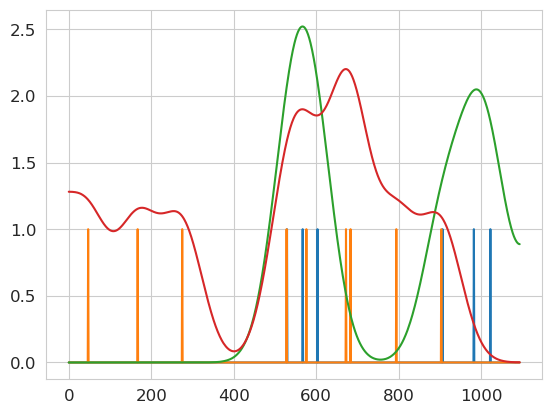

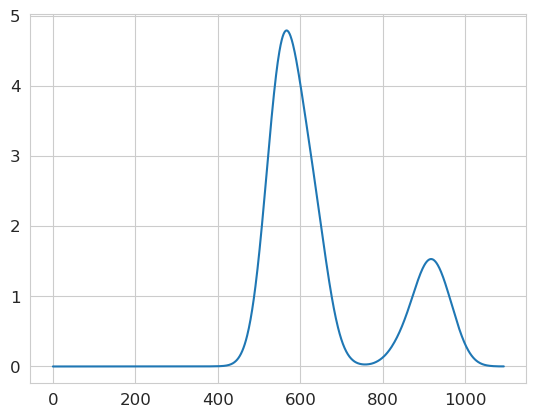

In [141]:
plt.figure()
plt.plot(spikes_binarized[0][0][0])
plt.plot(spikes_binarized[2][0][0])

plt.plot(spk_convol[0][0][0])
plt.plot(spk_convol[2][0][0])

plt.figure()
plt.plot(spk_convol[0][0][0]*spk_convol[2][0][0])

In [ ]:
def synchrony(Info_session, sigma, spk_convol):
    
    n_neurons = Info_session.n_neurons
    n_trials = Info_session.n_trials
    n_periods = Info_session.n_periods

    spk_sync = np.zeros((n_trials, n_periods-1, len(sigma), n_neurons, n_neurons))


    # correlation between neurons 
    for trial in range(n_trials):
        for per in range(n_periods - 1):
            for s in range(len(sigma)) :
                for neurone1 in range(n_neurons):
                    for neurone2 in range(n_neurons):
                        spk_sync[trial][per][s][neurone1][neurone2] = np.sum(
                            spk_convol[neurone1][trial][per][s]*spk_convol[neurone2][trial][per][s])
    
    return  spk_sync

spk_sync = compute_measures.synchrony(Info_session, sigma, spk_convol)

# Draft ?

In [ ]:
df_spk = pd.DataFrame(columns = df_task_ts.columns, index=df_task_ts.index)

n_units = len(spike_times)


for unit in range(4):
    filename = spike_times[unit][0][1]
    print(filename)
    # get contact and unit indices from filename
    match_probe = re.search(r'probe(\d+)', filename)
    match_contact = re.search(r'contact(\d+)', filename)
    match_unit = re.search(r'unit(\d+)', filename)

    probe_idx = int(match_probe.group(1))
    contact_idx = int(match_contact.group(1))
    unit_idx = int(match_unit.group(1))

    sub_data = info_session[(info_session['probe'] == probe_idx) & (info_session['channel'] == contact_idx) & (info_session['unit'] == unit_idx)]

    print(sub_data[['probe', 'channel' , 'unit']])
    print('\n')

    idx_min_trial = df_task_ts_by_neuron[unit][1].index[0]
    idx_max_trial = df_task_ts_by_neuron[unit][1].index[-1]
    idx_trials = np.arange(idx_min_trial, idx_max_trial + 1) 

    elitrials = sub_data['elitrials'].values[0]

    if elitrials is not None : 
        print(elitrials)
        # Initialize an empty array to store the result
        list_elitrials = np.array([])

        for trial_range in range(len(elitrials)):
            start = elitrials[trial_range][0]
            stop = elitrials[trial_range][-1]           
            
            # Create a range of values and concatenate it to the result
            list_elitrials = np.concatenate((list_elitrials, np.arange(start, stop + 1)))

        print(list_elitrials)

        # create the index list 
        print(idx_trials)
        print(f'{idx_trials.shape} - {len(list_elitrials)}') 

        # exclude elitrials 
        idx_trials = idx_trials[~np.isin(idx_trials, list_elitrials)]
        print(idx_trials)



In [444]:
def mean_fr_all_neurons(df_task_ts, spike_times): 
     
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_rate = []    
    n_neurons = len(spike_times)
    n_trials = df_task_ts.shape[0]
    n_events = df_task_ts.shape[1]
    spk_rate_arr = np.zeros((n_neurons, n_trials, n_events-1))


    for unit_idx in range(2):
        spk_rate.append([])
        print(f'NEURON {unit_idx}')


        for trial in range(5):
            spk_rate[unit_idx].append([])
            print(f'TRIAL : {trial}\n')

            for event in range(len(event_labels) - 1):
                print(event_labels[event])
                # define the start and end time of each trial
                t_start = df_task_ts.loc[trial][event]
                t_stop = df_task_ts.loc[trial][event + 1]
                print(t_start, t_stop)
                
                # get spikes between start and end of trial 
                spk_tmp = spike_times[unit_idx][1] 
                sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
                print(spk_tmp[sel_spk])
                
                spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop)
                mean = mean_firing_rate(spk_ts_trial)*1000 

                print(mean.magnitude)
               
                spk_rate_arr[neuron][trial][event] = mean.magnitude 

    return  spk_rate_arr 

In [445]:
spk_rate = mean_fr_all_neurons(df_task_ts, spike_times)

NEURON 0
TRIAL : 0

Touch_time
61233 62310
[]
0.0
Sel_ON
62310 63629
[]
0.0
SC1_ON
63629 64937
[64137]
0.764525993883792
SC2_ON
64937 66258
[]
0.0
SC3_ON
66258 67543
[66628]
0.7782101167315175
Go_time
67543 68156
[]
0.0
TRIAL : 1

Touch_time
105639 106751
[]
0.0
Sel_ON
106751 108096
[]
0.0
SC1_ON
108096 109404
[108504 108968]
1.529051987767584
SC2_ON
109404 110712
[109958]
0.764525993883792
SC3_ON
110712 111997
[]
0.0
Go_time
111997 112550
[]
0.0
TRIAL : 2

Touch_time
179281 180344
[179944]
0.9407337723424272
Sel_ON
180344 181696
[180353 180395 180575]
2.2189349112426036
SC1_ON
181696 183014
[]
0.0
SC2_ON
183014 184322
[]
0.0
SC3_ON
184322 185620
[184670 184688 185496]
2.3112480739599386
Go_time
185620 186341
[186233]
1.3869625520110958
TRIAL : 3

Touch_time
216446 217522
[216590 217100 217134 217168 217400]
4.646840148698885
Sel_ON
217522 218831
[217524 218113]
1.5278838808250572
SC1_ON
218831 220139
[219105]
0.764525993883792
SC2_ON
220139 221460
[220620]
0.757002271006813
SC3_ON
221

In [448]:
def structure_spk_rate(spk_rate, event_labels):
    n_units = spk_rate.shape[0]
    n_events = spk_rate.shape[2]
    list_df_spk = []

    # structure firing rate in DataFrame
    for unit_idx in range(n_units):
        for event in range(n_events):

            df_spk = pd.DataFrame(spk_rate[:,:,event])
            df_spk = df_spk.T
            df_spk.insert(0, 'period', event_labels[event])

        list_df_spk.append(df_spk)

    return list_df_spk

In [449]:
list_df_spk = structure_spk_rate(spk_rate, event_labels)

In [450]:
list_df_spk[0]

,period,0,1,2,3,4,5,6,7,8,...,33,34,35,36,37,38,39,40,41,42
0,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Go_time,25.316456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,Go_time,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def structure_spk_rate(Info_session, periods_names, spk_rate, target):
    n_periods = Info_session.n_periods
    list_df_spk = []

    # structure firing rate in DataFrame
    for per in range(n_periods - 1):

        df_spk = pd.DataFrame(spk_rate[:,:,per])
        df_spk = df_spk.T
        df_spk.insert(0, 'period', periods_names[per])

        idx_target = 0
        for target_name in target.keys(): 
            idx_target =+1
            df_spk.insert(idx_target, column= target_name, value=target[f'{target_name}'])
        
        list_df_spk.append(df_spk)

    return list_df_spk